# March Madness

Purpose: This notebook is intended to be able to create the optimal March Madness bracket.

### Outline

- Import Necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import os
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
from scipy.interpolate import UnivariateSpline
import statsmodels.api as sm
import matplotlib.pyplot as plt
import collections

pd.set_option("display.max_column", 999)

The data used for this project has been obtained from Kaggle. Every year Kaggle hosts a competition to see who can produce the best March Madness Bracket. The 2019 competition page can be found [here](https://www.kaggle.com/c/mens-machine-learning-competition-2019/overview). 

The regular_results data set contains box scores from NCAA Basketball games from the 2003 to 2019 seasons.

In [2]:
regular_results = pd.read_csv('Data/Stage2DataFiles/RegularSeasonDetailedResults.csv')

In [3]:
regular_results.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,8,20,10,19,15,28,16,13,4,4,18,24,67,6,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,8,18,17,29,17,26,15,10,5,2,25,22,73,3,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,3,9,17,31,6,19,11,12,14,2,18,18,49,6,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,6,14,11,13,17,22,12,14,4,4,20,24,62,6,16,17,27,21,15,12,10,7,1,14


Tourney_results has the same information as regular_results, but for games played in the NCAA tournament. 

In [4]:
tourney_results = pd.read_csv('Data/Stage2DataFiles/NCAATourneyDetailedResults.csv')

In [5]:
tourney_results.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,134,1421,92,1411,84,N,1,32,69,11,29,17,26,14,30,17,12,5,3,22,29,67,12,31,14,31,17,28,16,15,5,0,22
1,2003,136,1112,80,1436,51,N,0,31,66,7,23,11,14,11,36,22,16,10,7,8,20,64,4,16,7,7,8,26,12,17,10,3,15
2,2003,136,1113,84,1272,71,N,0,31,59,6,14,16,22,10,27,18,9,7,4,19,25,69,7,28,14,21,20,22,11,12,2,5,18
3,2003,136,1141,79,1166,73,N,0,29,53,3,7,18,25,11,20,15,18,13,1,19,27,60,7,17,12,17,14,17,20,21,6,6,21
4,2003,136,1143,76,1301,74,N,1,27,64,7,20,15,23,18,20,17,13,8,2,14,25,56,9,21,15,20,10,26,16,14,5,8,19


Seeds lists the seeds for every NCAA tournament team for every year from 1985 to 2019.

In [6]:
seeds = pd.read_csv('Data/Stage2DataFiles/NCAATourneySeeds.csv')

In [7]:
seeds.head()

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374


In [8]:
seeds.tail()

,Season,Seed,TeamID
2281,2019,Z12,1332
2282,2019,Z13,1414
2283,2019,Z14,1330
2284,2019,Z15,1159
2285,2019,Z16,1205


In [9]:
regular_results.columns

Index(['Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc',
       'NumOT', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR',
       'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3',
       'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF'],
      dtype='object')

Here I wrote a function to make some changes to the regular_results and tourney_results dataframes. I created a duplciate dataframe with the values for winning and losing teams reversed, and then changed the columns from representing winning and losing teams to just being team 1 and team 2. I did this that I can average out all of the data for each team. Furthermore, by having two rows for each game, it will allow me do find the point differential for each team in each game. The point differential indicates the difference in score at thend of the game. If a game ends 100-90, the point differential is 10. This metric is commonly used in basketball and is often thought of as a better predictor how good a team is at a particular point in time than that team's record. By having two rows for each team, I can now indicate a 10 for the winning team and a -10 for the losing team.

I also changed teh location information from home, away, and neutral to 1, -1, and 0, respectively.

In [10]:
def prepare_data(df):
    '''
    Take a dataframe and create a duplicate with the win and lose statistical columns flipped. Then change
    the WLoc column name to location in each data set. Then rename the columns in the flipped dataset to 
    indicate that they have been flipped. Concatenate the two files. Then take the labels indicating home, 
    away, and neutral locations, and change to 1, -1, and 0, respectively. Finally, create a point differential 
    column.
    
    -
    Inputs:
    The dataframe to be transformed
    -
    Outputs: 
    The transformed dataframe
    '''
        
    dfswap = df[['Season', 'DayNum', 'LTeamID', 'LScore', 'WTeamID', 'WScore', 'WLoc', 'NumOT', 
    'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF', 
    'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF']]

    dfswap.loc[df['WLoc'] == 'H', 'WLoc'] = 'A'
    dfswap.loc[df['WLoc'] == 'A', 'WLoc'] = 'H'
    df.columns.values[6] = 'location'
    dfswap.columns.values[6] = 'location'    
      
    df.columns = [x.replace('W','T1_').replace('L','T2_') for x in list(df.columns)]
    dfswap.columns = [x.replace('L','T1_').replace('W','T2_') for x in list(dfswap.columns)]

    output = pd.concat([df, dfswap]).reset_index(drop=True)
    output.loc[output.location=='N','location'] = '0'
    output.loc[output.location=='H','location'] = '1'
    output.loc[output.location=='A','location'] = '-1'
    output.location = output.location.astype(int)
    
    output['PointDiff'] = output['T1_Score'] - output['T2_Score']
    
    return output

Transform the regular season and tournament data using the previously created function.

In [11]:
regular_data = prepare_data(regular_results)
tourney_data = prepare_data(tourney_results)

Create a list of column names to be used for the groupby function, and also save the numpy function mean to a value funcs to be used by the groupby function.

In [12]:
boxscore_cols = ['T1_Score', 'T2_Score', 
        'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_FTM', 'T1_FTA', 'T1_OR', 'T1_DR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_Blk', 'T1_PF', 
        'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_FTM', 'T2_FTA', 'T2_OR', 'T2_DR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk', 'T2_PF', 
        'PointDiff']

# boxscore_cols = [
#         'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_OR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_PF', 
#         'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_OR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk',  
#         'PointDiff']

funcs = [np.mean]

Group the data by season and by team in order to find each team's averages for each of the statistics provided. This allows us to treat team 1 as the primary team and team 2 as the opponent of team 1. Therefore, not only do we have a team's season averages, but also their opponent's averages. These opponent averages indicate how well a team plays defense.

In [13]:
season_statistics = regular_data.groupby(["Season", 'T1_TeamID'])[boxscore_cols].agg(funcs).reset_index()
season_statistics.head()

,Season,T1_TeamID,T1_Score,T2_Score,T1_FGM,T1_FGA,T1_FGM3,T1_FGA3,T1_FTM,T1_FTA,T1_OR,T1_DR,T1_Ast,T1_TO,T1_Stl,T1_Blk,T1_PF,T2_FGM,T2_FGA,T2_FGM3,T2_FGA3,T2_FTM,T2_FTA,T2_OR,T2_DR,T2_Ast,T2_TO,T2_Stl,T2_Blk,T2_PF,PointDiff
,,,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
0,2003,1102,57.250000,57.000000,19.142857,39.785714,7.821429,20.821429,11.142857,17.107143,4.178571,16.821429,13.000000,11.428571,5.964286,1.785714,18.750000,19.285714,42.428571,4.750000,12.428571,13.678571,19.250000,9.607143,20.142857,9.142857,12.964286,5.428571,1.571429,18.357143,0.250000
1,2003,1103,78.777778,78.148148,27.148148,55.851852,5.444444,16.074074,19.037037,25.851852,9.777778,19.925926,15.222222,12.629630,7.259259,2.333333,19.851852,27.777778,57.000000,6.666667,18.370370,15.925926,22.148148,12.037037,22.037037,15.481481,15.333333,6.407407,2.851852,22.444444,0.629630
2,2003,1104,69.285714,65.000000,24.035714,57.178571,6.357143,19.857143,14.857143,20.928571,13.571429,23.928571,12.107143,13.285714,6.607143,3.785714,18.035714,23.250000,55.500000,6.357143,19.142857,12.142857,17.142857,10.892857,22.642857,11.678571,13.857143,5.535714,3.178571,19.250000,4.285714
3,2003,1105,71.769231,76.653846,24.384615,61.615385,7.576923,20.769231,15.423077,21.846154,13.500000,23.115385,14.538462,18.653846,9.307692,2.076923,20.230769,27.000000,58.961538,6.269231,17.538462,16.384615,24.500000,13.192308,26.384615,15.807692,18.807692,9.384615,4.192308,19.076923,-4.884615
4,2003,1106,63.607143,63.750000,23.428571,55.285714,6.107143,17.642857,10.642857,16.464286,12.285714,23.857143,11.678571,17.035714,8.357143,3.142857,18.178571,21.714286,53.392857,4.785714,15.214286,15.535714,21.964286,11.321429,22.357143,11.785714,15.071429,8.785714,3.178571,16.142857,-0.142857


Now I removed the mean label for each column and combined it with the original column label.

In [14]:
season_statistics.columns = [''.join(col).strip() for col in season_statistics.columns.values]
season_statistics.head()

,Season,T1_TeamID,T1_Scoremean,T2_Scoremean,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_FTMmean,T1_FTAmean,T1_ORmean,T1_DRmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_Blkmean,T1_PFmean,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_FTMmean,T2_FTAmean,T2_ORmean,T2_DRmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_Blkmean,T2_PFmean,PointDiffmean
0,2003,1102,57.250000,57.000000,19.142857,39.785714,7.821429,20.821429,11.142857,17.107143,4.178571,16.821429,13.000000,11.428571,5.964286,1.785714,18.750000,19.285714,42.428571,4.750000,12.428571,13.678571,19.250000,9.607143,20.142857,9.142857,12.964286,5.428571,1.571429,18.357143,0.250000
1,2003,1103,78.777778,78.148148,27.148148,55.851852,5.444444,16.074074,19.037037,25.851852,9.777778,19.925926,15.222222,12.629630,7.259259,2.333333,19.851852,27.777778,57.000000,6.666667,18.370370,15.925926,22.148148,12.037037,22.037037,15.481481,15.333333,6.407407,2.851852,22.444444,0.629630
2,2003,1104,69.285714,65.000000,24.035714,57.178571,6.357143,19.857143,14.857143,20.928571,13.571429,23.928571,12.107143,13.285714,6.607143,3.785714,18.035714,23.250000,55.500000,6.357143,19.142857,12.142857,17.142857,10.892857,22.642857,11.678571,13.857143,5.535714,3.178571,19.250000,4.285714
3,2003,1105,71.769231,76.653846,24.384615,61.615385,7.576923,20.769231,15.423077,21.846154,13.500000,23.115385,14.538462,18.653846,9.307692,2.076923,20.230769,27.000000,58.961538,6.269231,17.538462,16.384615,24.500000,13.192308,26.384615,15.807692,18.807692,9.384615,4.192308,19.076923,-4.884615
4,2003,1106,63.607143,63.750000,23.428571,55.285714,6.107143,17.642857,10.642857,16.464286,12.285714,23.857143,11.678571,17.035714,8.357143,3.142857,18.178571,21.714286,53.392857,4.785714,15.214286,15.535714,21.964286,11.321429,22.357143,11.785714,15.071429,8.785714,3.178571,16.142857,-0.142857


Here I created two new dataframes for team 1 and team 2 data. I then replaced the column labels in the T1 dataset that contained T2 with T1 opponent. I then changed the column labels in the T2 dataset from T1 to T2, and added opponent to the opponent columns.

In [15]:
season_statistics_T1 = season_statistics.copy()
season_statistics_T2 = season_statistics.copy()

season_statistics_T1.columns = ["T1_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(season_statistics_T1.columns)]
season_statistics_T2.columns = ["T2_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(season_statistics_T2.columns)]
season_statistics_T1.columns.values[0] = "Season"
season_statistics_T2.columns.values[0] = "Season"

In [16]:
season_statistics_T1.tail()

,Season,T1_TeamID,T1_Scoremean,T1_opponent_Scoremean,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_FTMmean,T1_FTAmean,T1_ORmean,T1_DRmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_Blkmean,T1_PFmean,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_FTMmean,T1_opponent_FTAmean,T1_opponent_ORmean,T1_opponent_DRmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_opponent_PFmean,T1_PointDiffmean
5829,2019,1462,71.878788,70.606061,26.121212,55.848485,7.000000,21.030303,12.636364,18.424242,10.424242,25.757576,14.787879,13.454545,5.424242,3.787879,15.757576,25.727273,59.363636,8.878788,25.090909,10.272727,14.636364,9.818182,22.121212,14.363636,11.060606,7.000000,3.030303,17.424242,1.272727
5830,2019,1463,80.892857,73.714286,29.821429,60.107143,7.785714,20.821429,13.464286,18.357143,8.678571,29.821429,17.000000,13.250000,5.750000,4.321429,17.000000,26.000000,63.035714,7.500000,24.071429,14.214286,19.285714,9.607143,24.357143,12.678571,11.214286,7.107143,2.964286,17.142857,7.178571
5831,2019,1464,73.500000,79.233333,26.833333,63.633333,9.566667,28.000000,10.266667,14.733333,12.966667,24.000000,13.633333,13.133333,6.100000,3.400000,20.766667,27.566667,58.466667,7.533333,22.033333,16.566667,22.533333,9.800000,25.766667,14.133333,11.500000,5.900000,3.333333,15.166667,-5.733333
5832,2019,1465,75.461538,75.192308,26.038462,59.038462,8.807692,25.230769,14.576923,18.961538,10.076923,26.269231,10.615385,12.500000,4.346154,2.615385,21.307692,25.769231,59.038462,6.576923,18.384615,17.076923,24.038462,10.769231,24.961538,11.230769,10.807692,5.538462,2.615385,18.346154,0.269231
5833,2019,1466,65.620690,74.931034,22.931034,59.655172,7.241379,24.344828,12.517241,18.379310,10.862069,25.103448,10.172414,13.655172,6.275862,2.137931,18.965517,26.068966,56.517241,7.344828,20.931034,15.448276,21.482759,8.413793,28.896552,13.793103,12.172414,6.517241,4.758621,16.172414,-9.310345


In [17]:
season_statistics_T2.tail()

,Season,T2_TeamID,T2_Scoremean,T2_opponent_Scoremean,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_FTMmean,T2_FTAmean,T2_ORmean,T2_DRmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_Blkmean,T2_PFmean,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_FTMmean,T2_opponent_FTAmean,T2_opponent_ORmean,T2_opponent_DRmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_opponent_PFmean,T2_PointDiffmean
5829,2019,1462,71.878788,70.606061,26.121212,55.848485,7.000000,21.030303,12.636364,18.424242,10.424242,25.757576,14.787879,13.454545,5.424242,3.787879,15.757576,25.727273,59.363636,8.878788,25.090909,10.272727,14.636364,9.818182,22.121212,14.363636,11.060606,7.000000,3.030303,17.424242,1.272727
5830,2019,1463,80.892857,73.714286,29.821429,60.107143,7.785714,20.821429,13.464286,18.357143,8.678571,29.821429,17.000000,13.250000,5.750000,4.321429,17.000000,26.000000,63.035714,7.500000,24.071429,14.214286,19.285714,9.607143,24.357143,12.678571,11.214286,7.107143,2.964286,17.142857,7.178571
5831,2019,1464,73.500000,79.233333,26.833333,63.633333,9.566667,28.000000,10.266667,14.733333,12.966667,24.000000,13.633333,13.133333,6.100000,3.400000,20.766667,27.566667,58.466667,7.533333,22.033333,16.566667,22.533333,9.800000,25.766667,14.133333,11.500000,5.900000,3.333333,15.166667,-5.733333
5832,2019,1465,75.461538,75.192308,26.038462,59.038462,8.807692,25.230769,14.576923,18.961538,10.076923,26.269231,10.615385,12.500000,4.346154,2.615385,21.307692,25.769231,59.038462,6.576923,18.384615,17.076923,24.038462,10.769231,24.961538,11.230769,10.807692,5.538462,2.615385,18.346154,0.269231
5833,2019,1466,65.620690,74.931034,22.931034,59.655172,7.241379,24.344828,12.517241,18.379310,10.862069,25.103448,10.172414,13.655172,6.275862,2.137931,18.965517,26.068966,56.517241,7.344828,20.931034,15.448276,21.482759,8.413793,28.896552,13.793103,12.172414,6.517241,4.758621,16.172414,-9.310345


Now, I am going to merge the season statistics dataframes to the tourney_data dataframe. 

In [18]:
tourney_data.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,location,NumOT,T1_FGM,T1_FGA,T1_FGM3,T1_FGA3,T1_FTM,T1_FTA,T1_OR,T1_DR,T1_Ast,T1_TO,T1_Stl,T1_Blk,T1_PF,T2_FGM,T2_FGA,T2_FGM3,T2_FGA3,T2_FTM,T2_FTA,T2_OR,T2_DR,T2_Ast,T2_TO,T2_Stl,T2_Blk,T2_PF,PointDiff
0,2003,134,1421,92,1411,84,0,1,32,69,11,29,17,26,14,30,17,12,5,3,22,29,67,12,31,14,31,17,28,16,15,5,0,22,8
1,2003,136,1112,80,1436,51,0,0,31,66,7,23,11,14,11,36,22,16,10,7,8,20,64,4,16,7,7,8,26,12,17,10,3,15,29
2,2003,136,1113,84,1272,71,0,0,31,59,6,14,16,22,10,27,18,9,7,4,19,25,69,7,28,14,21,20,22,11,12,2,5,18,13
3,2003,136,1141,79,1166,73,0,0,29,53,3,7,18,25,11,20,15,18,13,1,19,27,60,7,17,12,17,14,17,20,21,6,6,21,6
4,2003,136,1143,76,1301,74,0,1,27,64,7,20,15,23,18,20,17,13,8,2,14,25,56,9,21,15,20,10,26,16,14,5,8,19,2


Since I won't know the tournament statistics beforehand, I am going to remove that information. All that I will keep is Season, DayNum, T1_TeamID, T1_Score, T2_TeamID, and T2_Score.

In [19]:
tourney_data = tourney_data[['Season', 'DayNum', 'T1_TeamID', 'T1_Score', 'T2_TeamID' ,'T2_Score']]
tourney_data.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score
0,2003,134,1421,92,1411,84
1,2003,136,1112,80,1436,51
2,2003,136,1113,84,1272,71
3,2003,136,1141,79,1166,73
4,2003,136,1143,76,1301,74


In [20]:
tourney_data['location'].value_counts()

KeyError: 'location'

In [23]:
tourney_data = pd.merge(tourney_data, season_statistics_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, season_statistics_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [24]:
tourney_data.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_Scoremean,T1_opponent_Scoremean,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_FTMmean,T1_FTAmean,T1_ORmean,T1_DRmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_Blkmean,T1_PFmean,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_FTMmean,T1_opponent_FTAmean,T1_opponent_ORmean,T1_opponent_DRmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_opponent_PFmean,T1_PointDiffmean,T2_Scoremean,T2_opponent_Scoremean,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_FTMmean,T2_FTAmean,T2_ORmean,T2_DRmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_Blkmean,T2_PFmean,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_FTMmean,T2_opponent_FTAmean,T2_opponent_ORmean,T2_opponent_DRmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_opponent_PFmean,T2_PointDiffmean
0,2003,134,1421,92,1411,84,71.206897,78.448276,24.379310,56.793103,6.482759,18.000000,15.965517,20.931034,12.275862,23.172414,13.034483,16.206897,7.068966,3.000000,19.103448,27.793103,60.965517,7.620690,20.758621,15.241379,22.551724,13.724138,22.827586,15.862069,12.827586,8.827586,4.241379,18.689655,-7.241379,72.800000,70.833333,24.733333,55.266667,5.933333,18.500000,17.400000,28.066667,13.166667,24.800000,14.200000,15.233333,6.433333,2.233333,18.300000,25.666667,60.400000,7.533333,23.166667,11.966667,18.733333,11.933333,22.866667,13.766667,14.333333,8.000000,2.600000,21.633333,1.966667
1,2003,136,1112,80,1436,51,85.214286,70.250000,30.321429,65.714286,7.035714,20.071429,17.535714,25.000000,15.178571,27.642857,17.642857,14.785714,8.464286,4.214286,17.750000,26.357143,64.678571,6.321429,19.964286,11.214286,17.714286,13.107143,23.285714,15.464286,16.857143,5.964286,2.392857,22.071429,14.964286,67.793103,63.137931,24.827586,55.862069,5.275862,15.482759,12.862069,19.551724,12.965517,25.724138,14.206897,14.068966,6.862069,2.965517,15.896552,22.758621,55.068966,7.068966,21.448276,10.551724,15.758621,9.586207,21.862069,13.275862,13.000000,7.103448,3.655172,17.931034,4.655172
2,2003,136,1113,84,1272,71,75.965517,69.172414,27.206897,56.896552,4.000000,12.586207,17.551724,26.206897,13.689655,23.310345,15.551724,14.000000,5.206897,4.241379,19.413793,24.793103,55.655172,5.448276,15.896552,14.137931,20.517241,11.000000,20.551724,14.068966,15.517241,6.000000,3.931034,22.862069,6.793103,74.517241,65.827586,26.275862,60.000000,7.000000,20.068966,14.965517,22.896552,14.068966,25.965517,16.620690,13.793103,7.379310,5.068966,18.758621,23.275862,57.862069,5.896552,18.310345,13.379310,20.724138,12.344828,23.586207,13.310345,15.068966,7.275862,3.172414,19.931034,8.689655
3,2003,136,1141,79,1166,73,79.344828,73.241379,26.620690,52.689655,6.827586,17.931034,19.275862,25.172414,10.586207,23.275862,15.620690,18.241379,7.103448,4.000000,20.965517,26.344828,57.931034,4.965517,13.896552,15.586207,21.965517,12.241379,18.896552,11.793103,16.068966,8.448276,2.482759,21.689655,6.103448,79.242424,64.333333,28.696970,57.454545,7.969697,20.484848,13.878788,20.030303,10.878788,23.181818,16.818182,13.363636,8.393939,4.454545,17.272727,23.878788,55.333333,4.878788,14.303030,11.696970,16.696970,11.060606,21.363636,12.363636,17.060606,6.333333,2.575758,19.393939,14.909091
4,2003,136,1143,76,1301,74,74.482759,69.758621,27.344828,58.724138,6.413793,17.034483,13.379310,19.517241,11.241379,24.379310,16.000000,14.172414,6.551724,2.793103,17.103448,25.379310,58.793103,7.103448,21.448276,11.896552,17.448276,11.172414,23.000000,16.034483,14.931034,5.931034,2.517241,19.103448,4.724138,72.400000,68.000000,24.333333,53.333333,7.966667,22.500000,15.766667,20.466667,9.733333,22.033333,14.666667,14.200000,7.766667,3.066667,18.666667,23.433333,53.133333,5.733333,17.000000,15.400000,21.200000,10.533333,21.433333,12.566667,14.633333,7.433333,2.833333,19.333333,4.400000


Now I engineered a new feature, win_ratio_14, which finds each team's winning percentage over the last 14 days of the season. This feature is trying to capture which teams are hot going into the tournament.

In [25]:
last14days_stats_T1 = regular_data.loc[regular_data.DayNum>118].reset_index(drop=True)
last14days_stats_T1['win'] = np.where(last14days_stats_T1['PointDiff']>0,1,0)
last14days_stats_T1 = last14days_stats_T1.groupby(['Season','T1_TeamID'])['win'].mean().reset_index(name='T1_win_ratio_14d')

last14days_stats_T2 = regular_data.loc[regular_data.DayNum>118].reset_index(drop=True)
last14days_stats_T2['win'] = np.where(last14days_stats_T2['PointDiff']<0,1,0)
last14days_stats_T2 = last14days_stats_T2.groupby(['Season','T2_TeamID'])['win'].mean().reset_index(name='T2_win_ratio_14d')

Here, I am merging my newly created feature onto my primary dataframe.

In [26]:
tourney_data = pd.merge(tourney_data, last14days_stats_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, last14days_stats_T2, on = ['Season', 'T2_TeamID'], how = 'left')

Now I am engineering a new feature called team_quality. This is an attempt to create a metric that captures how good a team is at the end of the season. In this first step I created a new dataframe that includes all of the games in my dataset since 2003, including the two teams that played, the point differntial, and which team won.

In [27]:
regular_season_effects = regular_data[['Season','T1_TeamID','T2_TeamID','PointDiff']].copy()
regular_season_effects['T1_TeamID'] = regular_season_effects['T1_TeamID'].astype(str)
regular_season_effects['T2_TeamID'] = regular_season_effects['T2_TeamID'].astype(str)
regular_season_effects['win'] = np.where(regular_season_effects['PointDiff']>0,1,0)
march_madness = pd.merge(seeds[['Season','TeamID']],seeds[['Season','TeamID']],on='Season')
march_madness.columns = ['Season', 'T1_TeamID', 'T2_TeamID']
march_madness.T1_TeamID = march_madness.T1_TeamID.astype(str)
march_madness.T2_TeamID = march_madness.T2_TeamID.astype(str)
regular_season_effects = pd.merge(regular_season_effects, march_madness, on = ['Season','T1_TeamID','T2_TeamID'])
regular_season_effects.shape

(9914, 5)

Now I am creating a function that will find team quality when given a season.

In [28]:
def team_quality(season):
    '''
    Takes a season number as an input and uses the data from that year in the regular_season_effects dataframe. 
    That season's data is then put into a formula that is then run through a GLM model.
    
    -
    Inputs:
    Season number from 2003 to 2019
    -
    Outputs: 
    Quality rating for every team in the dataset for the given year
    '''
    formula = 'win~-1+T1_TeamID+T2_TeamID'
    glm = sm.GLM.from_formula(formula=formula, 
                              data=regular_season_effects.loc[regular_season_effects.Season==season,:], 
                              family=sm.families.Binomial()).fit()
    
    quality = pd.DataFrame(glm.params).reset_index()
    quality.columns = ['TeamID','quality']
    quality['Season'] = season
    quality['quality'] = np.exp(quality['quality'])
    quality = quality.loc[quality.TeamID.str.contains('T1_')].reset_index(drop=True)
    quality['TeamID'] = quality['TeamID'].apply(lambda x: x[10:14]).astype(int)
    return quality

This produces a dataframe with every team's rating for every season from 2010 to 2019.

In [29]:
glm_quality = pd.concat([team_quality(2010),
                         team_quality(2011),
                         team_quality(2012),
                         team_quality(2013),
                         team_quality(2014),
                         team_quality(2015),
                         team_quality(2016),
                         team_quality(2017),
                         team_quality(2018), 
                         team_quality(2019)]).reset_index(drop=True)

/Users/timothyphugele/.pyenv/versions/anaconda3-2019.10/envs/learn-env/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:894: RuntimeWarning: invalid value encountered in true_divide
  n_endog_mu = self._clean((1. - endog) / (1. - mu))
/Users/timothyphugele/.pyenv/versions/anaconda3-2019.10/envs/learn-env/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:894: RuntimeWarning: divide by zero encountered in true_divide
  n_endog_mu = self._clean((1. - endog) / (1. - mu))
/Users/timothyphugele/.pyenv/versions/anaconda3-2019.10/envs/learn-env/lib/python3.6/site-packages/statsmodels/genmod/families/links.py:188: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Users/timothyphugele/.pyenv/versions/anaconda3-2019.10/envs/learn-env/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:893: RuntimeWarning: divide by zero encountered in true_divide
  endog_mu = self._clean(endog / mu)
/Users/timothyphugele/.pyenv/versions/anaconda3-2019.10/

In [30]:
glm_quality

,TeamID,quality,Season
0,1115,1.843173e+05,2010
1,1124,2.980579e+23,2010
2,1139,7.119038e+22,2010
3,1140,7.356270e+22,2010
4,1143,2.524816e+22,2010
...,...,...,...
658,1439,2.317763e+232,2019
659,1449,1.578698e+231,2019
660,1458,1.777652e+232,2019
661,1459,3.077301e+214,2019


Now I created two identical dataframes from the quality dataframe in order to merge the quality ratings onto the main tourney_data dataframe.

In [31]:
glm_quality_T1 = glm_quality.copy()
glm_quality_T2 = glm_quality.copy()
glm_quality_T1.columns = ['T1_TeamID','T1_quality','Season']
glm_quality_T2.columns = ['T2_TeamID','T2_quality','Season']

In [32]:
tourney_data = pd.merge(tourney_data, glm_quality_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, glm_quality_T2, on = ['Season', 'T2_TeamID'], how = 'left')

Now I am going to merge the seed data onto the tourney_data dataframe.

In [33]:
seeds.tail()

,Season,Seed,TeamID
2281,2019,Z12,1332
2282,2019,Z13,1414
2283,2019,Z14,1330
2284,2019,Z15,1159
2285,2019,Z16,1205


In [34]:
seeds['seed'] = seeds['Seed'].apply(lambda x: int(x[1:3]))
seeds.head()

,Season,Seed,TeamID,seed
0,1985,W01,1207,1
1,1985,W02,1210,2
2,1985,W03,1228,3
3,1985,W04,1260,4
4,1985,W05,1374,5


In [35]:
seeds_T1 = seeds[['Season','TeamID','seed']].copy()
seeds_T2 = seeds[['Season','TeamID','seed']].copy()
seeds_T1.columns = ['Season','T1_TeamID','T1_seed']
seeds_T2.columns = ['Season','T2_TeamID','T2_seed']

In [36]:
tourney_data = pd.merge(tourney_data, seeds_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, seeds_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [37]:
tourney_data.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_Scoremean,T1_opponent_Scoremean,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_FTMmean,T1_FTAmean,T1_ORmean,T1_DRmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_Blkmean,T1_PFmean,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_FTMmean,T1_opponent_FTAmean,T1_opponent_ORmean,T1_opponent_DRmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_opponent_PFmean,T1_PointDiffmean,T2_Scoremean,T2_opponent_Scoremean,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_FTMmean,T2_FTAmean,T2_ORmean,T2_DRmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_Blkmean,T2_PFmean,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_FTMmean,T2_opponent_FTAmean,T2_opponent_ORmean,T2_opponent_DRmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_opponent_PFmean,T2_PointDiffmean,T1_win_ratio_14d,T2_win_ratio_14d,T1_quality,T2_quality,T1_seed,T2_seed
0,2003,134,1421,92,1411,84,71.206897,78.448276,24.379310,56.793103,6.482759,18.000000,15.965517,20.931034,12.275862,23.172414,13.034483,16.206897,7.068966,3.000000,19.103448,27.793103,60.965517,7.620690,20.758621,15.241379,22.551724,13.724138,22.827586,15.862069,12.827586,8.827586,4.241379,18.689655,-7.241379,72.800000,70.833333,24.733333,55.266667,5.933333,18.500000,17.400000,28.066667,13.166667,24.800000,14.200000,15.233333,6.433333,2.233333,18.300000,25.666667,60.400000,7.533333,23.166667,11.966667,18.733333,11.933333,22.866667,13.766667,14.333333,8.000000,2.600000,21.633333,1.966667,1.000000,0.833333,NaN,NaN,16,16
1,2003,136,1112,80,1436,51,85.214286,70.250000,30.321429,65.714286,7.035714,20.071429,17.535714,25.000000,15.178571,27.642857,17.642857,14.785714,8.464286,4.214286,17.750000,26.357143,64.678571,6.321429,19.964286,11.214286,17.714286,13.107143,23.285714,15.464286,16.857143,5.964286,2.392857,22.071429,14.964286,67.793103,63.137931,24.827586,55.862069,5.275862,15.482759,12.862069,19.551724,12.965517,25.724138,14.206897,14.068966,6.862069,2.965517,15.896552,22.758621,55.068966,7.068966,21.448276,10.551724,15.758621,9.586207,21.862069,13.275862,13.000000,7.103448,3.655172,17.931034,4.655172,0.666667,1.000000,NaN,NaN,1,16
2,2003,136,1113,84,1272,71,75.965517,69.172414,27.206897,56.896552,4.000000,12.586207,17.551724,26.206897,13.689655,23.310345,15.551724,14.000000,5.206897,4.241379,19.413793,24.793103,55.655172,5.448276,15.896552,14.137931,20.517241,11.000000,20.551724,14.068966,15.517241,6.000000,3.931034,22.862069,6.793103,74.517241,65.827586,26.275862,60.000000,7.000000,20.068966,14.965517,22.896552,14.068966,25.965517,16.620690,13.793103,7.379310,5.068966,18.758621,23.275862,57.862069,5.896552,18.310345,13.379310,20.724138,12.344828,23.586207,13.310345,15.068966,7.275862,3.172414,19.931034,8.689655,0.666667,0.750000,NaN,NaN,10,7
3,2003,136,1141,79,1166,73,79.344828,73.241379,26.620690,52.689655,6.827586,17.931034,19.275862,25.172414,10.586207,23.275862,15.620690,18.241379,7.103448,4.000000,20.965517,26.344828,57.931034,4.965517,13.896552,15.586207,21.965517,12.241379,18.896552,11.793103,16.068966,8.448276,2.482759,21.689655,6.103448,79.242424,64.333333,28.696970,57.454545,7.969697,20.484848,13.878788,20.030303,10.878788,23.181818,16.818182,13.363636,8.393939,4.454545,17.272727,23.878788,55.333333,4.878788,14.303030,11.696970,16.696970,11.060606,21.363636,12.363636,17.060606,6.333333,2.575758,19.393939,14.909091,1.000000,1.000000,NaN,NaN,11,6
4,2003,136,1143,76,1301,74,74.482759,69.758621,27.344828,58.724138,6.413793,17.034483,13.379310,19.517241,11.241379,24.379310,16.000000,14.172414,6.551724,2.793103,17.103448,25.379310,58.793103,7.103448,21.448276,11.896552,17.448276,11.172414,23.000000,16.034483,14.931034,5.931034,2.517241,19.103448,4.724138,72.400000,68.000000,24.333333,53.333333,7.966667,22.500000,15.766667,20.466667,9.733333,22.033333,14.666667,14.200000,7.766667,3.066667,18.666667,23.433333,53.13333

In addition to the seed data, I added a column for the seed difference between the two teams.

In [38]:
tourney_data["Seed_diff"] = tourney_data["T1_seed"] - tourney_data["T2_seed"]

In [39]:
tourney_data.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_Scoremean,T1_opponent_Scoremean,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_FTMmean,T1_FTAmean,T1_ORmean,T1_DRmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_Blkmean,T1_PFmean,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_FTMmean,T1_opponent_FTAmean,T1_opponent_ORmean,T1_opponent_DRmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_opponent_PFmean,T1_PointDiffmean,T2_Scoremean,T2_opponent_Scoremean,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_FTMmean,T2_FTAmean,T2_ORmean,T2_DRmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_Blkmean,T2_PFmean,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_FTMmean,T2_opponent_FTAmean,T2_opponent_ORmean,T2_opponent_DRmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_opponent_PFmean,T2_PointDiffmean,T1_win_ratio_14d,T2_win_ratio_14d,T1_quality,T2_quality,T1_seed,T2_seed,Seed_diff
0,2003,134,1421,92,1411,84,71.206897,78.448276,24.379310,56.793103,6.482759,18.000000,15.965517,20.931034,12.275862,23.172414,13.034483,16.206897,7.068966,3.000000,19.103448,27.793103,60.965517,7.620690,20.758621,15.241379,22.551724,13.724138,22.827586,15.862069,12.827586,8.827586,4.241379,18.689655,-7.241379,72.800000,70.833333,24.733333,55.266667,5.933333,18.500000,17.400000,28.066667,13.166667,24.800000,14.200000,15.233333,6.433333,2.233333,18.300000,25.666667,60.400000,7.533333,23.166667,11.966667,18.733333,11.933333,22.866667,13.766667,14.333333,8.000000,2.600000,21.633333,1.966667,1.000000,0.833333,NaN,NaN,16,16,0
1,2003,136,1112,80,1436,51,85.214286,70.250000,30.321429,65.714286,7.035714,20.071429,17.535714,25.000000,15.178571,27.642857,17.642857,14.785714,8.464286,4.214286,17.750000,26.357143,64.678571,6.321429,19.964286,11.214286,17.714286,13.107143,23.285714,15.464286,16.857143,5.964286,2.392857,22.071429,14.964286,67.793103,63.137931,24.827586,55.862069,5.275862,15.482759,12.862069,19.551724,12.965517,25.724138,14.206897,14.068966,6.862069,2.965517,15.896552,22.758621,55.068966,7.068966,21.448276,10.551724,15.758621,9.586207,21.862069,13.275862,13.000000,7.103448,3.655172,17.931034,4.655172,0.666667,1.000000,NaN,NaN,1,16,-15
2,2003,136,1113,84,1272,71,75.965517,69.172414,27.206897,56.896552,4.000000,12.586207,17.551724,26.206897,13.689655,23.310345,15.551724,14.000000,5.206897,4.241379,19.413793,24.793103,55.655172,5.448276,15.896552,14.137931,20.517241,11.000000,20.551724,14.068966,15.517241,6.000000,3.931034,22.862069,6.793103,74.517241,65.827586,26.275862,60.000000,7.000000,20.068966,14.965517,22.896552,14.068966,25.965517,16.620690,13.793103,7.379310,5.068966,18.758621,23.275862,57.862069,5.896552,18.310345,13.379310,20.724138,12.344828,23.586207,13.310345,15.068966,7.275862,3.172414,19.931034,8.689655,0.666667,0.750000,NaN,NaN,10,7,3
3,2003,136,1141,79,1166,73,79.344828,73.241379,26.620690,52.689655,6.827586,17.931034,19.275862,25.172414,10.586207,23.275862,15.620690,18.241379,7.103448,4.000000,20.965517,26.344828,57.931034,4.965517,13.896552,15.586207,21.965517,12.241379,18.896552,11.793103,16.068966,8.448276,2.482759,21.689655,6.103448,79.242424,64.333333,28.696970,57.454545,7.969697,20.484848,13.878788,20.030303,10.878788,23.181818,16.818182,13.363636,8.393939,4.454545,17.272727,23.878788,55.333333,4.878788,14.303030,11.696970,16.696970,11.060606,21.363636,12.363636,17.060606,6.333333,2.575758,19.393939,14.909091,1.000000,1.000000,NaN,NaN,11,6,5
4,2003,136,1143,76,1301,74,74.482759,69.758621,27.344828,58.724138,6.413793,17.034483,13.379310,19.517241,11.241379,24.379310,16.000000,14.172414,6.551724,2.793103,17.103448,25.379310,58.793103,7.103448,21.448276,11.896552,17.448276,11.172414,23.000000,16.034483,14.931034,5.931034,2.517241,19.103448,4.724138,72.400000,68.000000,24.333333,53.333333,7.966667,22.500000,15.766667,20.466667,9.733333,22.033333,14.666667,14.200000,7.766667,3.066667,18.66666

In [40]:
tourney_data['T1_quality'].value_counts()

0.000000e+00    79
inf             53
1.090213e+14     6
6.470601e+00     6
5.353435e+56     6
                ..
2.761867e+56     1
8.047559e-35     1
1.639107e-01     1
6.064750e+56     1
1.000000e+00     1
Name: T1_quality, Length: 533, dtype: int64

In [41]:
tourney_data.to_csv("Data/tourney_data.csv", index = None)

### Kenpom Ratings

In [39]:
kenpom = pd.read_csv('Data/kenpom_2020.csv')

In [40]:
regular_results.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,location,NumOT,T1_FGM,T1_FGA,T1_FGM3,T1_FGA3,T1_FTM,T1_FTA,T1_OR,T1_DR,T1_Ast,T1_TO,T1_Stl,T1_Blk,T1_PF,T2_FGM,T2_FGA,T2_FGM3,T2_FGA3,T2_FTM,T2_FTA,T2_OR,T2_DR,T2_Ast,T2_TO,T2_Stl,T2_Blk,T2_PF
0,2003,10,1104,68,1328,62,N,0,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,8,20,10,19,15,28,16,13,4,4,18,24,67,6,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,8,18,17,29,17,26,15,10,5,2,25,22,73,3,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,3,9,17,31,6,19,11,12,14,2,18,18,49,6,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,6,14,11,13,17,22,12,14,4,4,20,24,62,6,16,17,27,21,15,12,10,7,1,14


In [41]:
kenpom = kenpom[kenpom['Season'] != 2020]

In [42]:
kenpom = kenpom[['Season', 'TeamID', 'adjem']]

In [43]:
season_list = list(kenpom['Season'].unique())

In [44]:
for s in season_list:
    kenpom_rates = []
    df = kenpom[kenpom['Season'] == s]
    df.sort_values(by = 'adjem', ascending = False)
    rank_list = list(range(len(df)))
    for rank in rank_list:
        ranks = {'rank' : rank+1}
        kenpom_rates.append(ranks)
    kenpom_rates = pd.DataFrame(kenpom_rates)
    df = df.reset_index(drop = True)
    df['adjem_rank'] = kenpom_rates
    if s == 2019:
        new_df = df
    else:
        new_df = new_df.append(df)

new_df = new_df.reset_index(drop = True)

In [45]:
ranks_25 = []
# new_df[new_df['adjem_rank'] <= 25]
rank_list = list(new_df['adjem_rank'])
for rank in rank_list:
    if rank <= 25:
        ranks = {'rank_t25' : 1}
        ranks_25.append(ranks)
    else:
        ranks = {'rank_t25' : 0}
        ranks_25.append(ranks)

In [46]:
rank_t25_df = pd.DataFrame(ranks_25)

In [47]:
new_df['rank_t25'] = rank_t25_df

In [48]:
new_df = new_df[['Season', 'TeamID', 'rank_t25']]

In [49]:
new_df.head()

,Season,TeamID,rank_t25
0,2019,1438,1
1,2019,1211,1
2,2019,1181,1
3,2019,1277,1
4,2019,1276,1


In [50]:
top_25_T1 = new_df.copy()
top_25_T2 = new_df.copy()
top_25_T1.columns = ['Season', 'T1_TeamID', 'T1_rank_t25']
top_25_T2.columns = ['Season', 'T2_TeamID', 'T2_rank_t25']

In [51]:
regular_results_new = pd.merge(regular_results, top_25_T1, on = ['Season', 'T1_TeamID'], how = 'left')
regular_results_new = pd.merge(regular_results_new, top_25_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [52]:
regular_results_new['pt_diff'] = regular_results_new['T1_Score'] - regular_results_new['T2_Score']

In [53]:
win_loss = []
index = list(range(len(regular_results_new)))

for i in index:
    if regular_results_new['pt_diff'][i] > 0:
        w_l = {'win' : 1}
        win_loss.append(w_l)
    else:
        w_l = {'win' : 0}
        win_loss.append(w_l)

In [54]:
df_25 = pd.DataFrame(win_loss)

In [55]:
regular_results_new['win'] = df_25

In [56]:
regular_results_new.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,location,NumOT,T1_FGM,T1_FGA,T1_FGM3,T1_FGA3,T1_FTM,T1_FTA,T1_OR,T1_DR,T1_Ast,T1_TO,T1_Stl,T1_Blk,T1_PF,T2_FGM,T2_FGA,T2_FGM3,T2_FGA3,T2_FTM,T2_FTA,T2_OR,T2_DR,T2_Ast,T2_TO,T2_Stl,T2_Blk,T2_PF,T1_rank_t25,T2_rank_t25,pt_diff,win
0,2003,10,1104,68,1328,62,N,0,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20,0.0,1.0,6,1
1,2003,10,1272,70,1393,63,N,0,26,62,8,20,10,19,15,28,16,13,4,4,18,24,67,6,24,9,20,20,25,7,12,8,6,16,0.0,1.0,7,1
2,2003,11,1266,73,1437,61,N,0,24,58,8,18,17,29,17,26,15,10,5,2,25,22,73,3,26,14,23,31,22,9,12,2,5,23,1.0,0.0,12,1
3,2003,11,1296,56,1457,50,N,0,18,38,3,9,17,31,6,19,11,12,14,2,18,18,49,6,22,8,15,17,20,9,19,4,3,23,0.0,0.0,6,1
4,2003,11,1296,56,1457,50,N,0,18,38,3,9,17,31,6,19,11,12,14,2,18,18,49,6,22,8,15,17,20,9,19,4,3,23,0.0,0.0,6,1


In [57]:
regular_results_new = regular_results_new.drop_duplicates()

In [58]:
season_list[0]

2019

In [59]:
top_25_win_list = []
for s in season_list:
    season_25 = regular_results_new[regular_results_new['Season'] == s]
    all_teams = list(set(list(season_25['T1_TeamID'])))
    for teamID in all_teams:
        season_25_2 = season_25[season_25['T1_TeamID'] == teamID]
        season_25_2 = season_25_2.reset_index()
        index = list(range(len(season_25_2)))
        for i in index:
            if season_25_2['T2_rank_t25'][i] == 1:
                top_25_wins = {'Season' : s, 'T1_TeamID' : teamID, 't25_win' : 1}
                top_25_win_list.append(top_25_wins)
            else:
                top_25_wins = {'Season' : s, 'T1_TeamID' : teamID, 't25_win' : 0}
                top_25_win_list.append(top_25_wins)

In [60]:
top_25_win_df = pd.DataFrame(top_25_win_list)

In [61]:
num_of_wins = []
for s in season_list:
    temp = top_25_win_df[top_25_win_df['Season'] == s]
    all_teams = list(set(list(temp['T1_TeamID'])))
    for teamID in all_teams:
        season_25_2 = temp[temp['T1_TeamID'] == teamID]
        t25_wins = season_25_2['t25_win'].sum()
        t25_win_list = {'Season' : s, 'T1_TeamID': teamID, 'top_25_wins' : t25_wins}
        num_of_wins.append(t25_win_list)

In [62]:
num_of_wins_df = pd.DataFrame(num_of_wins)

In [63]:
num_of_wins_df.head()

,Season,T1_TeamID,top_25_wins
0,2019,1101,0
1,2019,1102,0
2,2019,1103,0
3,2019,1104,2
4,2019,1105,0


In [64]:
num_of_wins_df.to_csv("data/top_25_wins.csv", index = None)

### Modeling

I set the y value equal to the point differential for each game.

In [70]:
y = tourney_data['T1_Score'] - tourney_data['T2_Score']
y.describe()

count    2096.00000
mean        0.00000
std        14.28837
min       -56.00000
25%       -10.00000
50%         0.00000
75%        10.00000
max        56.00000
dtype: float64

I created a list of all the features that I plan to use in the model.

In [71]:
features = list(season_statistics_T1.columns[2:999]) + \
    list(season_statistics_T2.columns[2:999]) + \
    list(seeds_T1.columns[2:999]) + \
    list(seeds_T2.columns[2:999]) + \
    list(last14days_stats_T1.columns[2:999]) + \
    list(last14days_stats_T2.columns[2:999]) + \
    ["Seed_diff"] + ["T1_quality","T2_quality"]

len(features)

65

I set the X value equal to the features that I plan to use in the model, and then I used an XG Boost model.

In [72]:
X = tourney_data[features].values
dtrain = xgb.DMatrix(X, label = y)

/Users/timothyphugele/.pyenv/versions/anaconda3-2019.10/envs/learn-env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [73]:
def cauchyobj(preds, dtrain):
    '''
    Takes in predictions and an XG Boost Dtrain Matrix and returns the grad and hess.
    
    -
    Inputs:
    Predictions, XG Boost Dtrain Matrix
    -
    Outputs: 
    grad, hess
    '''
    labels = dtrain.get_label()
    c = 5000 
    x =  preds-labels    
    grad = x / (x**2/c**2+1)
    hess = -c**2*(x**2-c**2)/(x**2+c**2)**2
    return grad, hess

Here I am setting the parameters for the model.

In [74]:
param = {} 
#param['objective'] = 'reg:linear'
param['eval_metric'] =  'mae'
param['booster'] = 'gbtree'
param['eta'] = 0.05 #change to ~0.02 for final run
param['subsample'] = 0.35
param['colsample_bytree'] = 0.7
param['num_parallel_tree'] = 3 #recommend 10
param['min_child_weight'] = 40
param['gamma'] = 10
param['max_depth'] =  3
param['silent'] = 1

print(param)

{'eval_metric': 'mae', 'booster': 'gbtree', 'eta': 0.05, 'subsample': 0.35, 'colsample_bytree': 0.7, 'num_parallel_tree': 3, 'min_child_weight': 40, 'gamma': 10, 'max_depth': 3, 'silent': 1}


Now I am finding the mean absolute error for each XG Boost model for different cv values.

In [75]:
xgb_cv = []
repeat_cv = 3 # recommend 10

for i in range(repeat_cv): 
    print(f"Fold repeater {i}")
    xgb_cv.append(
        xgb.cv(
          params = param,
          dtrain = dtrain,
          obj = cauchyobj,
          num_boost_round = 3000,
          folds = KFold(n_splits = 5, shuffle = True, random_state = i),
          early_stopping_rounds = 25,
          verbose_eval = 50
        )
    )

Fold repeater 0
[0]	train-mae:11.2108+0.125302	test-mae:11.2161+0.489659
[50]	train-mae:8.43795+0.0507298	test-mae:8.87341+0.280905
[100]	train-mae:7.95749+0.0555628	test-mae:8.7664+0.273359
Fold repeater 1
[0]	train-mae:11.2151+0.0437352	test-mae:11.2259+0.183411
[50]	train-mae:8.43117+0.0565015	test-mae:8.89705+0.242504
[100]	train-mae:7.95542+0.0589562	test-mae:8.81294+0.217172
Fold repeater 2
[0]	train-mae:11.212+0.0691406	test-mae:11.2209+0.23231
[50]	train-mae:8.42469+0.0513734	test-mae:8.87727+0.255456
[100]	train-mae:7.94906+0.0433495	test-mae:8.78668+0.243965


In [76]:
iteration_counts = [np.argmin(x['test-mae-mean'].values) for x in xgb_cv]
val_mae = [np.min(x['test-mae-mean'].values) for x in xgb_cv]
iteration_counts, val_mae

([122, 122, 97], [8.7488602, 8.7959856, 8.7845564])

In [77]:
oof_preds = []
for i in range(repeat_cv):
    print(f"Fold repeater {i}")
    preds = y.copy()
    kfold = KFold(n_splits = 5, shuffle = True, random_state = i)    
    for train_index, val_index in kfold.split(X,y):
        dtrain_i = xgb.DMatrix(X[train_index], label = y[train_index])
        dval_i = xgb.DMatrix(X[val_index], label = y[val_index])  
        model = xgb.train(
              params = param,
              dtrain = dtrain_i,
              num_boost_round = iteration_counts[i],
              verbose_eval = 50
        )
        preds[val_index] = model.predict(dval_i)
    oof_preds.append(np.clip(preds,-30,30))

Fold repeater 0
Fold repeater 1
Fold repeater 2


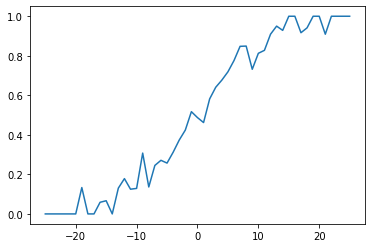

In [78]:
plot_df = pd.DataFrame({"pred":oof_preds[0], "label":np.where(y>0,1,0)})
plot_df["pred_int"] = plot_df["pred"].astype(int)
plot_df = plot_df.groupby('pred_int')['label'].mean().reset_index(name='average_win_pct')

plt.figure()
plt.plot(plot_df.pred_int,plot_df.average_win_pct)

In [79]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
        
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    
    print(f"logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

logloss of cvsplit 0: 0.5454237895796934
logloss of cvsplit 1: 0.5484430818858793
logloss of cvsplit 2: 0.5470038089120369


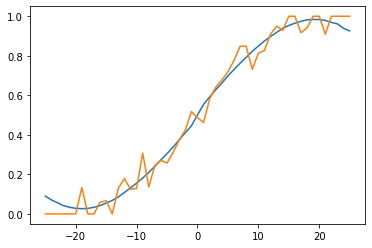

In [80]:
plot_df = pd.DataFrame({"pred":oof_preds[0], "label":np.where(y>0,1,0), "spline":spline_model[0](oof_preds[0])})
plot_df["pred_int"] = (plot_df["pred"]).astype(int)
plot_df = plot_df.groupby('pred_int')['spline','label'].mean().reset_index()

plt.figure()
plt.plot(plot_df.pred_int,plot_df.spline)
plt.plot(plot_df.pred_int,plot_df.label)

In [81]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit,0.025,0.975)
    
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

adjusted logloss of cvsplit 0: 0.5453833629713292
adjusted logloss of cvsplit 1: 0.5484518107279376
adjusted logloss of cvsplit 2: 0.5470233410222397


In [82]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit,0.025,0.975)
    spline_fit[(tourney_data.T1_seed==1) & (tourney_data.T2_seed==16)] = 1.0
    spline_fit[(tourney_data.T1_seed==2) & (tourney_data.T2_seed==15)] = 1.0
    spline_fit[(tourney_data.T1_seed==3) & (tourney_data.T2_seed==14)] = 1.0
    spline_fit[(tourney_data.T1_seed==4) & (tourney_data.T2_seed==13)] = 1.0
    spline_fit[(tourney_data.T1_seed==16) & (tourney_data.T2_seed==1)] = 0.0
    spline_fit[(tourney_data.T1_seed==15) & (tourney_data.T2_seed==2)] = 0.0
    spline_fit[(tourney_data.T1_seed==14) & (tourney_data.T2_seed==3)] = 0.0
    spline_fit[(tourney_data.T1_seed==13) & (tourney_data.T2_seed==4)] = 0.0
    
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}")

adjusted logloss of cvsplit 0: 1.3279183068809837
adjusted logloss of cvsplit 1: 1.3302644241924229
adjusted logloss of cvsplit 2: 1.330820067177648


In [83]:
pd.concat(
    [tourney_data[(tourney_data.T1_seed==1) & (tourney_data.T2_seed==16) & (tourney_data.T1_Score < tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==2) & (tourney_data.T2_seed==15) & (tourney_data.T1_Score < tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==3) & (tourney_data.T2_seed==14) & (tourney_data.T1_Score < tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==4) & (tourney_data.T2_seed==13) & (tourney_data.T1_Score < tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==16) & (tourney_data.T2_seed==1) & (tourney_data.T1_Score > tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==15) & (tourney_data.T2_seed==2) & (tourney_data.T1_Score > tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==14) & (tourney_data.T2_seed==3) & (tourney_data.T1_Score > tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==13) & (tourney_data.T2_seed==4) & (tourney_data.T1_Score > tourney_data.T2_Score)]]
)   

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_Scoremean,T1_opponent_Scoremean,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_FTMmean,T1_FTAmean,T1_ORmean,T1_DRmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_Blkmean,T1_PFmean,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_FTMmean,T1_opponent_FTAmean,T1_opponent_ORmean,T1_opponent_DRmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_opponent_PFmean,T1_PointDiffmean,T2_Scoremean,T2_opponent_Scoremean,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_FTMmean,T2_FTAmean,T2_ORmean,T2_DRmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_Blkmean,T2_PFmean,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_FTMmean,T2_opponent_FTAmean,T2_opponent_ORmean,T2_opponent_DRmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_opponent_PFmean,T2_PointDiffmean,T1_win_ratio_14d,T2_win_ratio_14d,T1_quality,T2_quality,T1_seed,T2_seed,Seed_diff
2062,2018,137,1438,54,1420,74,67.545455,53.393939,25.000000,54.181818,7.363636,18.878788,10.181818,13.424242,8.393939,24.272727,13.727273,8.575758,6.787879,3.727273,14.060606,18.818182,50.151515,6.151515,20.303030,9.606061,13.121212,8.393939,22.212121,8.848485,12.727273,3.878788,2.636364,15.060606,14.151515,72.483871,70.967742,25.612903,58.451613,9.838710,25.774194,11.419355,17.580645,9.709677,24.354839,14.870968,11.677419,7.387097,2.548387,16.516129,25.322581,56.612903,8.322581,23.161290,12.000000,17.580645,9.935484,27.129032,13.580645,14.322581,6.258065,2.806452,18.774194,1.516129,1.000000,1.000000,inf,0.000000e+00,1,16,-15
1653,2012,137,1181,70,1250,75,77.515152,68.454545,25.757576,56.272727,8.121212,21.606061,17.878788,25.484848,11.909091,24.666667,12.454545,12.181818,6.242424,4.030303,18.181818,25.515152,58.909091,4.454545,14.060606,12.969697,18.787879,11.696970,22.393939,11.151515,12.909091,5.666667,2.666667,20.787879,9.060606,75.625000,65.406250,25.750000,57.812500,7.406250,20.875000,16.718750,21.593750,10.843750,24.718750,13.000000,11.531250,7.812500,2.906250,17.781250,23.187500,55.562500,5.968750,17.906250,13.062500,18.500000,10.218750,23.656250,13.062500,14.687500,5.687500,3.843750,18.750000,10.218750,0.500000,1.000000,5.127021e+00,9.514450e-18,2,15,-13
1656,2012,137,1281,84,1313,86,80.294118,65.735294,28.000000,55.588235,8.235294,20.823529,16.058824,20.970588,9.176471,23.029412,16.205882,10.294118,8.205882,2.823529,14.117647,24.617647,55.794118,6.235294,17.205882,10.264706,15.176471,10.764706,20.764706,12.823529,14.411765,5.264706,2.647059,18.735294,14.558824,69.562500,66.750000,24.312500,54.281250,5.343750,17.031250,15.593750,23.750000,11.187500,24.937500,12.000000,14.812500,6.531250,4.750000,19.093750,23.375000,57.687500,5.625000,18.468750,14.375000,21.437500,12.281250,22.218750,11.093750,13.656250,6.593750,3.125000,20.125000,2.812500,1.000000,1.000000,8.116465e+00,8.750486e-18,2,15,-13
1716,2013,137,1207,68,1195,78,64.580645,55.741935,23.000000,50.419355,5.870968,16.419355,12.709677,18.677419,9.225806,23.709677,14.806452,12.677419,7.548387,3.838710,16.870968,19.419355,51.612903,5.354839,17.580645,11.548387,17.354839,10.806452,20.935484,10.903226,14.225806,6.354839,3.290323,18.322581,8.838710,72.343750,67.312500,26.218750,57.500000,6.625000,20.031250,13.281250,19.812500,11.687500,24.750000,13.718750,14.656250,8.812500,3.781250,17.593750,23.625000,57.468750,6.875000,21.843750,13.187500,18.906250,12.000000,23.562500,13.281250,15.656250,6.937500,3.031250,17.750000,5.031250,0.500000,1.000000,4.979810e+00,1.554166e+00,2,15,-13
1918,2016,137,1277,81,1292,90,79.764706,63.382353,28.794118,59.529412,9.117647,21.029412,13.058824,17.882353,12.294118,29.558824,20.558824,11.794118,4.411765,5.147059,19.088235,21.794118,57.823529,5.676471,18.794118,14.117647,19.676471,9.352941,20.735294,10.617647,9.558824,5.323529,3.235294,17.558824,16.382353,72.322581,68.225806,25.903226,57.709677,8.000000,20.580645,12.516129,2

In [84]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit,0.025,0.975)
    spline_fit[(tourney_data.T1_seed==1) & (tourney_data.T2_seed==16) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==2) & (tourney_data.T2_seed==15) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==3) & (tourney_data.T2_seed==14) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==4) & (tourney_data.T2_seed==13) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==16) & (tourney_data.T2_seed==1) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==15) & (tourney_data.T2_seed==2) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==14) & (tourney_data.T2_seed==3) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==13) & (tourney_data.T2_seed==4) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

adjusted logloss of cvsplit 0: 0.5197944228294208
adjusted logloss of cvsplit 1: 0.5220865502175349
adjusted logloss of cvsplit 2: 0.5220551919585454


In [85]:
val_cv = []
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit,0.025,0.975)
    spline_fit[(tourney_data.T1_seed==1) & (tourney_data.T2_seed==16) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==2) & (tourney_data.T2_seed==15) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==3) & (tourney_data.T2_seed==14) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==4) & (tourney_data.T2_seed==13) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==16) & (tourney_data.T2_seed==1) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==15) & (tourney_data.T2_seed==2) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==14) & (tourney_data.T2_seed==3) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==13) & (tourney_data.T2_seed==4) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    
    val_cv.append(pd.DataFrame({"y":np.where(y>0,1,0), "pred":spline_fit, "season":tourney_data.Season}))
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 
    
val_cv = pd.concat(val_cv)
val_cv.groupby('season').apply(lambda x: log_loss(x.y, x.pred))


adjusted logloss of cvsplit 0: 0.5197944228294208
adjusted logloss of cvsplit 1: 0.5220865502175349
adjusted logloss of cvsplit 2: 0.5220551919585454


season
2003    0.520886
2004    0.492120
2005    0.484649
2006    0.531319
2007    0.419793
2008    0.458391
2009    0.473997
2010    0.549072
2011    0.572092
2012    0.555587
2013    0.565865
2014    0.569355
2015    0.504013
2016    0.545845
2017    0.496785
2018    0.590465
dtype: float64

In [86]:
sub = pd.read_csv('Data/SampleSubmissionStage2.csv')
sub.head()

,ID,Pred
0,2019_1101_1113,0.5
1,2019_1101_1120,0.5
2,2019_1101_1124,0.5
3,2019_1101_1125,0.5
4,2019_1101_1133,0.5


In [87]:
len(sub)

2278

In [88]:
sub["Season"] = 2019
sub["T1_TeamID"] = sub["ID"].apply(lambda x: x[5:9]).astype(int)
sub["T2_TeamID"] = sub["ID"].apply(lambda x: x[10:14]).astype(int)
sub.head()

,ID,Pred,Season,T1_TeamID,T2_TeamID
0,2019_1101_1113,0.5,2019,1101,1113
1,2019_1101_1120,0.5,2019,1101,1120
2,2019_1101_1124,0.5,2019,1101,1124
3,2019_1101_1125,0.5,2019,1101,1125
4,2019_1101_1133,0.5,2019,1101,1133


In [89]:
sub = pd.merge(sub, season_statistics_T1, on = ['Season', 'T1_TeamID'])
sub = pd.merge(sub, season_statistics_T2, on = ['Season', 'T2_TeamID'])
sub = pd.merge(sub, glm_quality_T1, on = ['Season', 'T1_TeamID'])
sub = pd.merge(sub, glm_quality_T2, on = ['Season', 'T2_TeamID'])
sub = pd.merge(sub, seeds_T1, on = ['Season', 'T1_TeamID'])
sub = pd.merge(sub, seeds_T2, on = ['Season', 'T2_TeamID'])
sub = pd.merge(sub, last14days_stats_T1, on = ['Season', 'T1_TeamID'])
sub = pd.merge(sub, last14days_stats_T2, on = ['Season', 'T2_TeamID'])
sub["Seed_diff"] = sub["T1_seed"] - sub["T2_seed"]
sub.head()

,ID,Pred,Season,T1_TeamID,T2_TeamID,T1_Scoremean,T1_opponent_Scoremean,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_FTMmean,T1_FTAmean,T1_ORmean,T1_DRmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_Blkmean,T1_PFmean,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_FTMmean,T1_opponent_FTAmean,T1_opponent_ORmean,T1_opponent_DRmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_opponent_PFmean,T1_PointDiffmean,T2_Scoremean,T2_opponent_Scoremean,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_FTMmean,T2_FTAmean,T2_ORmean,T2_DRmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_Blkmean,T2_PFmean,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_FTMmean,T2_opponent_FTAmean,T2_opponent_ORmean,T2_opponent_DRmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_opponent_PFmean,T2_PointDiffmean,T1_quality,T2_quality,T1_seed,T2_seed,T1_win_ratio_14d,T2_win_ratio_14d,Seed_diff
0,2019_1101_1113,0.5,2019,1101,1113,71.724138,64.896552,25.344828,55.241379,7.241379,18.896552,13.793103,19.068966,9.068966,22.896552,14.62069,11.655172,8.00000,2.551724,19.137931,22.482759,51.137931,5.724138,17.103448,14.206897,19.655172,8.827586,23.758621,11.103448,15.724138,5.551724,2.965517,18.068966,6.827586,77.812500,73.062500,26.593750,59.468750,7.250000,21.250000,17.375000,25.906250,12.156250,27.812500,13.593750,13.593750,6.218750,3.218750,19.906250,24.218750,58.687500,8.562500,25.500000,16.062500,22.656250,10.000000,25.218750,13.281250,13.906250,6.343750,3.468750,21.656250,4.750000,8.564360e+214,1.910598e+232,15,11,1.000000,0.666667,4
1,2019_1101_1120,0.5,2019,1101,1120,71.724138,64.896552,25.344828,55.241379,7.241379,18.896552,13.793103,19.068966,9.068966,22.896552,14.62069,11.655172,8.00000,2.551724,19.137931,22.482759,51.137931,5.724138,17.103448,14.206897,19.655172,8.827586,23.758621,11.103448,15.724138,5.551724,2.965517,18.068966,6.827586,78.882353,68.588235,27.029412,60.441176,11.411765,29.970588,13.411765,18.735294,11.735294,21.941176,14.411765,12.147059,9.294118,4.764706,18.382353,23.235294,52.941176,8.323529,23.382353,13.794118,19.352941,10.764706,24.176471,12.029412,17.588235,5.911765,3.676471,17.205882,10.294118,8.564360e+214,1.084702e+232,15,5,1.000000,1.000000,10
2,2019_1113_1120,0.5,2019,1113,1120,77.812500,73.062500,26.593750,59.468750,7.250000,21.250000,17.375000,25.906250,12.156250,27.812500,13.59375,13.593750,6.21875,3.218750,19.906250,24.218750,58.687500,8.562500,25.500000,16.062500,22.656250,10.000000,25.218750,13.281250,13.906250,6.343750,3.468750,21.656250,4.750000,78.882353,68.588235,27.029412,60.441176,11.411765,29.970588,13.411765,18.735294,11.735294,21.941176,14.411765,12.147059,9.294118,4.764706,18.382353,23.235294,52.941176,8.323529,23.382353,13.794118,19.352941,10.764706,24.176471,12.029412,17.588235,5.911765,3.676471,17.205882,10.294118,1.910598e+232,1.084702e+232,11,5,0.666667,1.000000,6
3,2019_1101_1124,0.5,2019,1101,1124,71.724138,64.896552,25.344828,55.241379,7.241379,18.896552,13.793103,19.068966,9.068966,22.896552,14.62069,11.655172,8.00000,2.551724,19.137931,22.482759,51.137931,5.724138,17.103448,14.206897,19.655172,8.827586,23.758621,11.103448,15.724138,5.551724,2.965517,18.068966,6.827586,71.656250,67.187500,25.500000,57.906250,7.937500,23.375000,12.718750,18.875000,13.375000,24.593750,13.843750,13.281250,6.125000,4.750000,18.781250,23.218750,55.031250,7.093750,20.781250,13.656250,20.093750,9.968750,21.687500,12.843750,12.406250,5.968750,4.218750,18.031250,4.468750,8.564360e+214,1.539317e+232,15,9,1.000000,0.000000,6
4,2019_1113_1124,0.5,2019,1113,1124,77.812500,73.062500,26.593750,59.468750,7.250000,21.250000,17.375000,25.906250,12.156250,27.812500,13.59375,13.593750,6.21875,3.218750,19.906250,24.218750,58.687500,8.562500,25.500000,16.062500,22.656250,10.000000,25.218750,13.281250,13.906250,6.343750,3.468750,21.656250,4.750000,71.656250,67.187500,25.500000,57.906250,7.937500,23.

In [90]:
len(sub)

2145

In [91]:
Xsub = sub[features].values
dtest = xgb.DMatrix(Xsub)

In [92]:
sub_models = []
for i in range(repeat_cv):
    print(f"Fold repeater {i}")
    sub_models.append(
        xgb.train(
          params = param,
          dtrain = dtrain,
          num_boost_round = int(iteration_counts[i] * 1.05),
          verbose_eval = 50
        )
    )

Fold repeater 0
Fold repeater 1
Fold repeater 2


In [93]:
sub_preds = []
for i in range(repeat_cv):
    sub_preds.append(np.clip(spline_model[i](np.clip(sub_models[i].predict(dtest),-30,30)),0.025,0.975))
    
sub["Pred"] = pd.DataFrame(sub_preds).mean(axis=0)

sub.loc[(sub.T1_seed==1) & (sub.T2_seed==16), 'Pred'] = 1.0
sub.loc[(sub.T1_seed==2) & (sub.T2_seed==15), 'Pred'] = 1.0
sub.loc[(sub.T1_seed==3) & (sub.T2_seed==14), 'Pred'] = 1.0
sub.loc[(sub.T1_seed==4) & (sub.T2_seed==13), 'Pred'] = 1.0
sub.loc[(sub.T1_seed==16) & (sub.T2_seed==1), 'Pred'] = 0.0
sub.loc[(sub.T1_seed==15) & (sub.T2_seed==2), 'Pred'] = 0.0
sub.loc[(sub.T1_seed==14) & (sub.T2_seed==3), 'Pred'] = 0.0
sub.loc[(sub.T1_seed==13) & (sub.T2_seed==4), 'Pred'] = 0.0

sub[['ID','Pred']].to_csv("Data/paris-submission.csv", index = None)

In [94]:
paris = pd.read_csv('Data/paris-submission.csv')

In [95]:
paris

,ID,Pred
0,2019_1101_1113,0.466681
1,2019_1101_1120,0.119785
2,2019_1113_1120,0.176886
3,2019_1101_1124,0.318353
4,2019_1113_1124,0.333358
...,...,...
2140,2019_1438_1463,0.951859
2141,2019_1439_1463,0.837899
2142,2019_1449_1463,0.706588
2143,2019_1458_1463,0.781658


### 2019 Results

In [96]:
teams_df = pd.read_csv('Data/Stage2DataFiles/Teams.csv')

In [97]:
teams_df = teams_df[['TeamID', 'TeamName']]

In [98]:
tourney_2019 = []

In [99]:
teams_df[teams_df['TeamName'] == "Virginia"]

,TeamID,TeamName
337,1438,Virginia


In [100]:
# Play in Round
matchups = {'Season' : 2019, 'T1_TeamID' : 1192, 'T2_TeamID' : 1341, 'win' : 1}
tourney_2019.append(matchups)
matchups = {'Season' : 2019, 'T1_TeamID' : 1125, 'T2_TeamID' : 1396, 'win' : 1}
tourney_2019.append(matchups)
matchups = {'Season' : 2019, 'T1_TeamID' : 1295, 'T2_TeamID' : 1300, 'win' : 1}
tourney_2019.append(matchups)
matchups = {'Season' : 2019, 'T1_TeamID' : 1113, 'T2_TeamID' : 1385, 'win' : 1}
tourney_2019.append(matchups)
# East Region, 1st Round
matchups = {'Season' : 2019, 'T1_TeamID' : 1181, 'T2_TeamID' : 1295, 'win' : 1}
tourney_2019.append(matchups)
matchups = {'Season' : 2019, 'T1_TeamID' : 1416, 'T2_TeamID' : 1433, 'win' : 1}
tourney_2019.append(matchups)
matchups = {'Season' : 2019, 'T1_TeamID' : 1251, 'T2_TeamID' : 1280, 'win' : 1}
tourney_2019.append(matchups)
matchups = {'Season' : 2019, 'T1_TeamID' : 1387, 'T2_TeamID' : 1439, 'win' : 0}
tourney_2019.append(matchups)
matchups = {'Season' : 2019, 'T1_TeamID' : 1125, 'T2_TeamID' : 1268, 'win' : 0}
tourney_2019.append(matchups)
matchups = {'Season' : 2019, 'T1_TeamID' : 1261, 'T2_TeamID' : 1463, 'win' : 1}
tourney_2019.append(matchups)
matchups = {'Season' : 2019, 'T1_TeamID' : 1257, 'T2_TeamID' : 1278, 'win' : 0}
tourney_2019.append(matchups)
matchups = {'Season' : 2019, 'T1_TeamID' : 1133, 'T2_TeamID' : 1277, 'win' : 0}
tourney_2019.append(matchups)
# East Region, 2nd Round
matchups = {'Season' : 2019, 'T1_TeamID' : 1181, 'T2_TeamID' : 1416, 'win' : 1}
tourney_2019.append(matchups)
matchups = {'Season' : 2019, 'T1_TeamID' : 1251, 'T2_TeamID' : 1439, 'win' : 0}
tourney_2019.append(matchups)
matchups = {'Season' : 2019, 'T1_TeamID' : 1261, 'T2_TeamID' : 1268, 'win' : 1}
tourney_2019.append(matchups)
matchups = {'Season' : 2019, 'T1_TeamID' : 1277, 'T2_TeamID' : 1278, 'win' : 1}
tourney_2019.append(matchups)
# East Region Sweet 16
matchups = {'Season' : 2019, 'T1_TeamID' : 1181, 'T2_TeamID' : 1439, 'win' : 1}
tourney_2019.append(matchups)
matchups = {'Season' : 2019, 'T1_TeamID' : 1261, 'T2_TeamID' : 1277, 'win' : 0}
tourney_2019.append(matchups)
# East Region Elite 8
matchups = {'Season' : 2019, 'T1_TeamID' : 1181, 'T2_TeamID' : 1277, 'win' : 0}
tourney_2019.append(matchups)

In [101]:
# West Region, 1st Round
matchups = {'Season' : 2019, 'T1_TeamID' : 1192, 'T2_TeamID' : 1211, 'win' : 0}
tourney_2019.append(matchups)
matchups = {'Season' : 2019, 'T1_TeamID' : 1124, 'T2_TeamID' : 1393, 'win' : 1}
tourney_2019.append(matchups)
matchups = {'Season' : 2019, 'T1_TeamID' : 1266, 'T2_TeamID' : 1293, 'win' : 0}
tourney_2019.append(matchups)
matchups = {'Season' : 2019, 'T1_TeamID' : 1199, 'T2_TeamID' : 1436, 'win' : 1}
tourney_2019.append(matchups)
matchups = {'Season' : 2019, 'T1_TeamID' : 1113, 'T2_TeamID' : 1138, 'win' : 0}
tourney_2019.append(matchups)
matchups = {'Season' : 2019, 'T1_TeamID' : 1297, 'T2_TeamID' : 1403, 'win' : 0}
tourney_2019.append(matchups)
matchups = {'Season' : 2019, 'T1_TeamID' : 1196, 'T2_TeamID' : 1305, 'win' : 1}
tourney_2019.append(matchups)
matchups = {'Season' : 2019, 'T1_TeamID' : 1276, 'T2_TeamID' : 1285, 'win' : 1}
tourney_2019.append(matchups)
# West Region, 2nd Round
matchups = {'Season' : 2019, 'T1_TeamID' : 1124, 'T2_TeamID' : 1211, 'win' : 0}
tourney_2019.append(matchups)
matchups = {'Season' : 2019, 'T1_TeamID' : 1199, 'T2_TeamID' : 1293, 'win' : 1}
tourney_2019.append(matchups)
matchups = {'Season' : 2019, 'T1_TeamID' : 1138, 'T2_TeamID' : 1403, 'win' : 0}
tourney_2019.append(matchups)
matchups = {'Season' : 2019, 'T1_TeamID' : 1196, 'T2_TeamID' : 1276, 'win' : 0}
tourney_2019.append(matchups)
# West Region Sweet 16
matchups = {'Season' : 2019, 'T1_TeamID' : 1199, 'T2_TeamID' : 1211, 'win' : 0}
tourney_2019.append(matchups)
matchups = {'Season' : 2019, 'T1_TeamID' : 1276, 'T2_TeamID' : 1403, 'win' : 0}
tourney_2019.append(matchups)
# West Region Elite 8
matchups = {'Season' : 2019, 'T1_TeamID' : 1211, 'T2_TeamID' : 1403, 'win' : 0}
tourney_2019.append(matchups)

In [102]:
# South Region, 1st Round
matchups = {'Season' : 2019, 'T1_TeamID' : 1205, 'T2_TeamID' : 1438, 'win' : 0}
tourney_2019.append(matchups)
matchups = {'Season' : 2019, 'T1_TeamID' : 1279, 'T2_TeamID' : 1328, 'win' : 0}
tourney_2019.append(matchups)
matchups = {'Season' : 2019, 'T1_TeamID' : 1332, 'T2_TeamID' : 1458, 'win' : 1}
tourney_2019.append(matchups)
matchups = {'Season' : 2019, 'T1_TeamID' : 1243, 'T2_TeamID' : 1414, 'win' : 0}
tourney_2019.append(matchups)
matchups = {'Season' : 2019, 'T1_TeamID' : 1388, 'T2_TeamID' : 1437, 'win' : 0}
tourney_2019.append(matchups)
matchups = {'Season' : 2019, 'T1_TeamID' : 1330, 'T2_TeamID' : 1345, 'win' : 0}
tourney_2019.append(matchups)
matchups = {'Season' : 2019, 'T1_TeamID' : 1153, 'T2_TeamID' : 1234, 'win' : 0}
tourney_2019.append(matchups)
matchups = {'Season' : 2019, 'T1_TeamID' : 1159, 'T2_TeamID' : 1397, 'win' : 1}
tourney_2019.append(matchups)
# South Region, 2nd Round
matchups = {'Season' : 2019, 'T1_TeamID' : 1328, 'T2_TeamID' : 1438, 'win' : 0}
tourney_2019.append(matchups)
matchups = {'Season' : 2019, 'T1_TeamID' : 1332, 'T2_TeamID' : 1414, 'win' : 1}
tourney_2019.append(matchups)
matchups = {'Season' : 2019, 'T1_TeamID' : 1345, 'T2_TeamID' : 1437, 'win' : 1}
tourney_2019.append(matchups)
matchups = {'Season' : 2019, 'T1_TeamID' : 1234, 'T2_TeamID' : 1397, 'win' : 0}
tourney_2019.append(matchups)
# South Region Sweet 16
matchups = {'Season' : 2019, 'T1_TeamID' : 1332, 'T2_TeamID' : 1438, 'win' : 0}
tourney_2019.append(matchups)
matchups = {'Season' : 2019, 'T1_TeamID' : 1345, 'T2_TeamID' : 1397, 'win' : 1}
tourney_2019.append(matchups)
# South Region Elite 8
matchups = {'Season' : 2019, 'T1_TeamID' : 1345, 'T2_TeamID' : 1438, 'win' : 0}
tourney_2019.append(matchups)

In [103]:
# Midwest Region, 1st Round
matchups = {'Season' : 2019, 'T1_TeamID' : 1233, 'T2_TeamID' : 1314, 'win' : 0}
tourney_2019.append(matchups)
matchups = {'Season' : 2019, 'T1_TeamID' : 1429, 'T2_TeamID' : 1449, 'win' : 0}
tourney_2019.append(matchups)
matchups = {'Season' : 2019, 'T1_TeamID' : 1120, 'T2_TeamID' : 1308, 'win' : 1}
tourney_2019.append(matchups)
matchups = {'Season' : 2019, 'T1_TeamID' : 1242, 'T2_TeamID' : 1318, 'win' : 1}
tourney_2019.append(matchups)
matchups = {'Season' : 2019, 'T1_TeamID' : 1235, 'T2_TeamID' : 1326, 'win' : 0}
tourney_2019.append(matchups)
matchups = {'Season' : 2019, 'T1_TeamID' : 1209, 'T2_TeamID' : 1222, 'win' : 0}
tourney_2019.append(matchups)
matchups = {'Season' : 2019, 'T1_TeamID' : 1371, 'T2_TeamID' : 1459, 'win' : 0}
tourney_2019.append(matchups)
matchups = {'Season' : 2019, 'T1_TeamID' : 1101, 'T2_TeamID' : 1246, 'win' : 0}
tourney_2019.append(matchups)
# Midwest Region, 2nd Round
matchups = {'Season' : 2019, 'T1_TeamID' : 1314, 'T2_TeamID' : 1449, 'win' : 1}
tourney_2019.append(matchups)
matchups = {'Season' : 2019, 'T1_TeamID' : 1120, 'T2_TeamID' : 1242, 'win' : 1}
tourney_2019.append(matchups)
matchups = {'Season' : 2019, 'T1_TeamID' : 1222, 'T2_TeamID' : 1326, 'win' : 1}
tourney_2019.append(matchups)
matchups = {'Season' : 2019, 'T1_TeamID' : 1246, 'T2_TeamID' : 1459, 'win' : 1}
tourney_2019.append(matchups)
# Midwest Region Sweet 16
matchups = {'Season' : 2019, 'T1_TeamID' : 1120, 'T2_TeamID' : 1314, 'win' : 1}
tourney_2019.append(matchups)
matchups = {'Season' : 2019, 'T1_TeamID' : 1222, 'T2_TeamID' : 1246, 'win' : 0}
tourney_2019.append(matchups)
# Midwest Region Elite 8
matchups = {'Season' : 2019, 'T1_TeamID' : 1120, 'T2_TeamID' : 1246, 'win' : 1}
tourney_2019.append(matchups)

In [104]:
# Final Four
matchups = {'Season' : 2019, 'T1_TeamID' : 1277, 'T2_TeamID' : 1403, 'win' : 0}
tourney_2019.append(matchups)
matchups = {'Season' : 2019, 'T1_TeamID' : 1120, 'T2_TeamID' : 1438, 'win' : 0}
tourney_2019.append(matchups)
# Championship
matchups = {'Season' : 2019, 'T1_TeamID' : 1403, 'T2_TeamID' : 1438, 'win' : 0}
tourney_2019.append(matchups)

In [105]:
len(tourney_2019)

67

In [106]:
results_2019 = pd.DataFrame(tourney_2019)

In [107]:
results_2019.shape

(67, 4)

In [108]:
results_2019 = pd.merge(results_2019, season_statistics_T1, on = ['Season', 'T1_TeamID'], how = 'left')
results_2019 = pd.merge(results_2019, season_statistics_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [109]:
results_2019.shape

(67, 62)

In [110]:
results_2019 = pd.merge(results_2019, last14days_stats_T1, on = ['Season', 'T1_TeamID'], how = 'left')
results_2019 = pd.merge(results_2019, last14days_stats_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [111]:
results_2019 = pd.merge(results_2019, seeds_T1, on = ['Season', 'T1_TeamID'], how = 'left')
results_2019 = pd.merge(results_2019, seeds_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [112]:
results_2019["Seed_diff"] = results_2019["T1_seed"] - results_2019["T2_seed"]

In [113]:
results_2019.head()

,Season,T1_TeamID,T2_TeamID,win,T1_Scoremean,T1_opponent_Scoremean,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_FTMmean,T1_FTAmean,T1_ORmean,T1_DRmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_Blkmean,T1_PFmean,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_FTMmean,T1_opponent_FTAmean,T1_opponent_ORmean,T1_opponent_DRmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_opponent_PFmean,T1_PointDiffmean,T2_Scoremean,T2_opponent_Scoremean,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_FTMmean,T2_FTAmean,T2_ORmean,T2_DRmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_Blkmean,T2_PFmean,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_FTMmean,T2_opponent_FTAmean,T2_opponent_ORmean,T2_opponent_DRmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_opponent_PFmean,T2_PointDiffmean,T1_win_ratio_14d,T2_win_ratio_14d,T1_seed,T2_seed,Seed_diff
0,2019,1192,1341,1,74.741935,72.483871,26.193548,55.225806,7.806452,19.322581,14.548387,19.548387,9.225806,23.096774,13.935484,13.451613,7.516129,3.645161,16.741935,26.193548,58.290323,7.709677,22.451613,12.387097,17.612903,11.451613,22.193548,13.483871,14.129032,6.193548,3.290323,17.677419,2.258065,74.848485,72.727273,25.515152,58.606061,6.181818,19.666667,17.636364,25.878788,11.212121,21.969697,12.303030,12.606061,8.818182,1.606061,21.696970,24.606061,54.272727,6.000000,19.454545,17.515152,25.272727,11.333333,26.545455,12.818182,17.939394,5.121212,4.303030,22.090909,2.121212,1.000000,1.000000,16,16,0
1,2019,1125,1396,1,86.866667,74.666667,31.666667,63.733333,10.366667,27.966667,13.166667,17.900000,8.900000,29.666667,19.600000,11.600000,6.666667,3.800000,15.700000,27.333333,63.766667,7.666667,22.133333,12.333333,17.666667,9.500000,25.933333,12.166667,12.233333,6.200000,3.700000,16.533333,12.200000,74.843750,71.156250,26.406250,60.218750,7.500000,22.687500,14.531250,19.875000,9.718750,24.562500,14.468750,11.156250,8.656250,2.250000,17.468750,25.406250,57.625000,7.187500,22.000000,13.156250,19.437500,10.343750,26.812500,12.687500,14.875000,5.500000,2.531250,16.812500,3.687500,0.500000,0.666667,11,11,0
2,2019,1295,1300,1,72.290323,73.741935,24.580645,54.709677,9.709677,26.354839,13.419355,17.548387,6.580645,24.193548,11.322581,10.645161,4.741935,2.483871,15.129032,27.387097,58.161290,7.612903,20.774194,11.354839,15.225806,8.258065,25.161290,12.322581,9.806452,5.322581,2.741935,16.870968,-1.451613,67.700000,67.866667,24.266667,54.933333,6.266667,20.100000,12.900000,18.333333,11.533333,24.933333,14.433333,15.500000,5.266667,2.566667,18.033333,24.933333,56.266667,6.033333,19.133333,11.966667,17.400000,9.200000,21.833333,13.100000,11.966667,6.133333,3.800000,15.966667,-0.166667,1.000000,0.750000,16,16,0
3,2019,1113,1385,1,77.812500,73.062500,26.593750,59.468750,7.250000,21.250000,17.375000,25.906250,12.156250,27.812500,13.593750,13.593750,6.218750,3.218750,19.906250,24.218750,58.687500,8.562500,25.500000,16.062500,22.656250,10.000000,25.218750,13.281250,13.906250,6.343750,3.468750,21.656250,4.750000,77.515152,74.787879,27.939394,61.545455,8.515152,23.575758,13.121212,18.090909,7.636364,24.909091,14.030303,10.363636,8.818182,3.333333,19.060606,25.181818,57.939394,8.424242,24.727273,16.000000,22.606061,10.545455,28.121212,13.636364,15.454545,5.181818,2.424242,17.000000,2.727273,0.666667,0.333333,11,11,0
4,2019,1181,1295,1,83.500000,67.558824,30.500000,63.911765,7.264706,24.058824,15.235294,22.088235,13.382353,28.382353,15.911765,13.117647,9.470588,6.823529,15.852941,25.235294,63.852941,6.500000,22.117647,10.588235,15.323529,11.970588,23.676471,12.294118,14.764706,6.529412,3.176471,17.676471,15.941176,72.290323,73.741935,24.580645,54.709677,9.709677,26.354839,13.419355,17.548387,6.580645,24.193548,11.322581,10.645161,4.741935,2.483871,15.129032,27.387097,58.161290,7.612903,20.774194,11.354839,15.225806,8.258065,25.161290,12.322581,9.806452,5.322581,2.741935,16.

In [114]:
results_2019.to_csv("Data/results_2019.csv", index = None)

### Submission File

In [115]:
sub

,ID,Pred,Season,T1_TeamID,T2_TeamID,T1_Scoremean,T1_opponent_Scoremean,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_FTMmean,T1_FTAmean,T1_ORmean,T1_DRmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_Blkmean,T1_PFmean,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_FTMmean,T1_opponent_FTAmean,T1_opponent_ORmean,T1_opponent_DRmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_opponent_PFmean,T1_PointDiffmean,T2_Scoremean,T2_opponent_Scoremean,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_FTMmean,T2_FTAmean,T2_ORmean,T2_DRmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_Blkmean,T2_PFmean,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_FTMmean,T2_opponent_FTAmean,T2_opponent_ORmean,T2_opponent_DRmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_opponent_PFmean,T2_PointDiffmean,T1_quality,T2_quality,T1_seed,T2_seed,T1_win_ratio_14d,T2_win_ratio_14d,Seed_diff
0,2019_1101_1113,0.466681,2019,1101,1113,71.724138,64.896552,25.344828,55.241379,7.241379,18.896552,13.793103,19.068966,9.068966,22.896552,14.620690,11.655172,8.000000,2.551724,19.137931,22.482759,51.137931,5.724138,17.103448,14.206897,19.655172,8.827586,23.758621,11.103448,15.724138,5.551724,2.965517,18.068966,6.827586,77.812500,73.062500,26.593750,59.468750,7.250000,21.250000,17.375000,25.906250,12.156250,27.812500,13.593750,13.593750,6.218750,3.218750,19.906250,24.218750,58.687500,8.562500,25.500000,16.062500,22.656250,10.000000,25.218750,13.281250,13.906250,6.343750,3.468750,21.656250,4.750000,8.564360e+214,1.910598e+232,15,11,1.000000,0.666667,4
1,2019_1101_1120,0.119785,2019,1101,1120,71.724138,64.896552,25.344828,55.241379,7.241379,18.896552,13.793103,19.068966,9.068966,22.896552,14.620690,11.655172,8.000000,2.551724,19.137931,22.482759,51.137931,5.724138,17.103448,14.206897,19.655172,8.827586,23.758621,11.103448,15.724138,5.551724,2.965517,18.068966,6.827586,78.882353,68.588235,27.029412,60.441176,11.411765,29.970588,13.411765,18.735294,11.735294,21.941176,14.411765,12.147059,9.294118,4.764706,18.382353,23.235294,52.941176,8.323529,23.382353,13.794118,19.352941,10.764706,24.176471,12.029412,17.588235,5.911765,3.676471,17.205882,10.294118,8.564360e+214,1.084702e+232,15,5,1.000000,1.000000,10
2,2019_1113_1120,0.176886,2019,1113,1120,77.812500,73.062500,26.593750,59.468750,7.250000,21.250000,17.375000,25.906250,12.156250,27.812500,13.593750,13.593750,6.218750,3.218750,19.906250,24.218750,58.687500,8.562500,25.500000,16.062500,22.656250,10.000000,25.218750,13.281250,13.906250,6.343750,3.468750,21.656250,4.750000,78.882353,68.588235,27.029412,60.441176,11.411765,29.970588,13.411765,18.735294,11.735294,21.941176,14.411765,12.147059,9.294118,4.764706,18.382353,23.235294,52.941176,8.323529,23.382353,13.794118,19.352941,10.764706,24.176471,12.029412,17.588235,5.911765,3.676471,17.205882,10.294118,1.910598e+232,1.084702e+232,11,5,0.666667,1.000000,6
3,2019_1101_1124,0.318353,2019,1101,1124,71.724138,64.896552,25.344828,55.241379,7.241379,18.896552,13.793103,19.068966,9.068966,22.896552,14.620690,11.655172,8.000000,2.551724,19.137931,22.482759,51.137931,5.724138,17.103448,14.206897,19.655172,8.827586,23.758621,11.103448,15.724138,5.551724,2.965517,18.068966,6.827586,71.656250,67.187500,25.500000,57.906250,7.937500,23.375000,12.718750,18.875000,13.375000,24.593750,13.843750,13.281250,6.125000,4.750000,18.781250,23.218750,55.031250,7.093750,20.781250,13.656250,20.093750,9.968750,21.687500,12.843750,12.406250,5.968750,4.218750,18.031250,4.468750,8.564360e+214,1.539317e+232,15,9,1.000000,0.000000,6
4,2019_1113_1124,0.333358,2019,1113,1124,77.812500,73.062500,26.593750,59.468750,7.250000,21.250000,17.375000,25.906250,12.156250,27.812500,13.593750,13.593750,6.218750,3.218750,19.906250,24.218750,58.687500,8.562500,25.500000,16.062500,22.656250,10.000000,25.218750,13.281250,13.906250,6.343750,3.468750,21.656250,4.750000,71.656250,67.1875

In [116]:
teams_1 = teams_df[['TeamID','TeamName']].copy()
teams_2 = teams_df[['TeamID','TeamName']].copy()

teams_1.columns = ['T1_TeamID','TeamName_1']
teams_2.columns = ['T2_TeamID','TeamName_2']

In [117]:
teams_1.head()

,T1_TeamID,TeamName_1
0,1101,Abilene Chr
1,1102,Air Force
2,1103,Akron
3,1104,Alabama
4,1105,Alabama A&M


In [118]:
sub = pd.merge(sub, teams_1, on = ['T1_TeamID'], how = 'left')
sub = pd.merge(sub, teams_2, on = ['T2_TeamID'], how = 'left')

In [119]:
sub_preds = sub[['TeamName_1', 'TeamName_2', 'Pred']]

In [120]:
sub_preds[sub_preds['TeamName_2'] == 'Gonzaga']

,TeamName_1,TeamName_2,Pred
78,Abilene Chr,Gonzaga,0.033652
79,Arizona St,Gonzaga,0.070948
80,Auburn,Gonzaga,0.311471
81,Baylor,Gonzaga,0.166631
82,Belmont,Gonzaga,0.148254
83,Buffalo,Gonzaga,0.249500
84,Cincinnati,Gonzaga,0.302900
85,Colgate,Gonzaga,0.025885
86,Duke,Gonzaga,0.523865
87,Florida,Gonzaga,0.226194


In [121]:
sub_preds['TeamName_2'].unique()

array(['Arizona St', 'Auburn', 'Baylor', 'Belmont', 'Buffalo',
       'Cincinnati', 'Colgate', 'Duke', 'Florida', 'Florida St',
       'Gardner Webb', 'Georgia St', 'Gonzaga', 'Houston', 'Iona', 'Iowa',
       'Iowa St', 'Kansas', 'Kansas St', 'Kentucky', 'Liberty',
       'Louisville', 'LSU', 'Marquette', 'Maryland', 'Michigan',
       'Michigan St', 'Minnesota', 'Mississippi', 'Mississippi St',
       'Montana', 'Murray St', 'N Dakota St', 'N Kentucky', 'NC Central',
       'Nevada', 'New Mexico St', 'North Carolina', 'Northeastern',
       'Ohio St', 'Oklahoma', 'Old Dominion', 'Oregon', 'Prairie View',
       'Purdue', 'Seton Hall', "St John's", 'St Louis', "St Mary's CA",
       'Syracuse', 'Temple', 'Tennessee', 'Texas Tech', 'UC Irvine',
       'UCF', 'Utah St', 'VA Commonwealth', 'Vermont', 'Villanova',
       'Virginia', 'Virginia Tech', 'Washington', 'Wisconsin', 'Wofford',
       'Yale'], dtype=object)

In [122]:
sub_preds['TeamName_1'].unique()

array(['Abilene Chr', 'Arizona St', 'Auburn', 'Baylor', 'Belmont',
       'Buffalo', 'Cincinnati', 'Colgate', 'Duke', 'Florida',
       'Florida St', 'Gardner Webb', 'Georgia St', 'Gonzaga', 'Houston',
       'Iona', 'Iowa', 'Iowa St', 'Kansas', 'Kansas St', 'Kentucky',
       'Liberty', 'Louisville', 'LSU', 'Marquette', 'Maryland',
       'Michigan', 'Michigan St', 'Minnesota', 'Mississippi',
       'Mississippi St', 'Montana', 'Murray St', 'N Dakota St',
       'N Kentucky', 'NC Central', 'Nevada', 'New Mexico St',
       'North Carolina', 'Northeastern', 'Ohio St', 'Oklahoma',
       'Old Dominion', 'Oregon', 'Prairie View', 'Purdue', 'Seton Hall',
       "St John's", 'St Louis', "St Mary's CA", 'Syracuse', 'Temple',
       'Tennessee', 'Texas Tech', 'UC Irvine', 'UCF', 'Utah St',
       'VA Commonwealth', 'Vermont', 'Villanova', 'Virginia',
       'Virginia Tech', 'Washington', 'Wisconsin', 'Wofford'],
      dtype=object)

In [123]:
teams_df[teams_df['TeamName'] == 'F Dickinson']

,TeamID,TeamName
91,1192,F Dickinson


In [124]:
tourney_results[tourney_results['T2_TeamID'] == 1192]

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,location,NumOT,T1_FGM,T1_FGA,T1_FGM3,T1_FGA3,T1_FTM,T1_FTA,T1_OR,T1_DR,T1_Ast,T1_TO,T1_Stl,T1_Blk,T1_PF,T2_FGM,T2_FGA,T2_FGM3,T2_FGA3,T2_FTM,T2_FTA,T2_OR,T2_DR,T2_Ast,T2_TO,T2_Stl,T2_Blk,T2_PF
133,2005,136,1228,67,1192,55,N,0,23,54,6,21,15,21,8,22,16,8,8,2,13,23,57,4,16,5,11,15,27,11,17,6,3,19
847,2016,134,1195,96,1192,65,N,0,34,57,8,23,20,34,10,42,27,18,6,4,18,23,70,8,23,11,18,9,24,16,9,9,1,26


In [125]:
sub = pd.read_csv('Data/SampleSubmissionStage2.csv')
sub.head()

,ID,Pred
0,2019_1101_1113,0.5
1,2019_1101_1120,0.5
2,2019_1101_1124,0.5
3,2019_1101_1125,0.5
4,2019_1101_1133,0.5


In [126]:
sub["Season"] = 2019
sub["T1_TeamID"] = sub["ID"].apply(lambda x: x[5:9]).astype(int)
sub["T2_TeamID"] = sub["ID"].apply(lambda x: x[10:14]).astype(int)
sub.head()

,ID,Pred,Season,T1_TeamID,T2_TeamID
0,2019_1101_1113,0.5,2019,1101,1113
1,2019_1101_1120,0.5,2019,1101,1120
2,2019_1101_1124,0.5,2019,1101,1124
3,2019_1101_1125,0.5,2019,1101,1125
4,2019_1101_1133,0.5,2019,1101,1133
